# Workers ring fire monitoring

In [87]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthenticator
from cassandra.query import dict_factory
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

In [3]:
seeds = ['127.0.0.1', '10.7.0.10', '10.7.0.21']

In [4]:
cluster = Cluster(contact_points=seeds, port=9042) #, auth_provider=auth_provider)

In [99]:
session = cluster.connect(keyspace='temp')
session.row_factory = pandas_factory
session.default_fetch_size = 50

In [340]:
# fetch data from cassandra db
cql = "select toTimeStamp(id) as date, ip, last_run, worker_last_run, message, workers_count from temp.log limit 50;"
res = session.execute(cql, timeout=5)
df = res._current_rows
df = df.set_index('date')
df['timestamp'] = np.int64(df.index.to_series().apply(pd.Timestamp).astype(int).values / 1e6)

df1 = df[df.ip=='79.111.12.34']
df2 = df[df.ip=='195.68.129.2']

start_ts = int(df.index.min().timestamp()*1000)
end_ts = int(df.index.max().timestamp()*1000)

df.head(10)

,ip,last_run,worker_last_run,message,workers_count,timestamp
date,,,,,,
2018-06-29 16:56:52.885,79.111.12.34,2018-06-29 16:56:49.793,2018-06-29 16:56:49.793,"worker=GORO, delay=3000",2,1530291412885
2018-06-29 16:56:49.546,79.111.12.34,2018-06-29 16:56:46.216,2018-06-29 16:56:46.216,"worker=GORO, delay=3000",2,1530291409545
2018-06-29 16:56:47.585,195.68.129.2,2018-06-29 16:56:44.719,2018-06-29 16:56:44.719,"worker=Ganymede, delay=3000",2,1530291407585
2018-06-29 16:56:46.322,79.111.12.34,2018-06-29 16:56:43.031,2018-06-29 16:56:43.031,"worker=GORO, delay=3000",2,1530291406321
2018-06-29 16:56:44.597,195.68.129.2,2018-06-29 16:56:41.655,2018-06-29 16:56:41.655,"worker=Ganymede, delay=3000",2,1530291404597
2018-06-29 16:56:42.955,79.111.12.34,2018-06-29 16:56:39.633,2018-06-29 16:56:39.633,"worker=GORO, delay=3000",2,1530291402955
2018-06-29 16:56:41.387,195.68.129.2,2018-06-29 16:56:38.523,2018-06-29 16:56:38.523,"worker=Ganymede, delay=3000",2,1530291401387
2018-06-29 16:56:39.660,79.111.12.34,2018-06-29 16:56:36.294,2018-06-29 16:56:36.294,"worker=GORO, delay=3000",2,1530291399660
2018-06-29 16:56:38.356,195.68.129.2,2018-06-29 16:56:35.357,2018-06-29 16:56:35.357,"worker=Ganymede, delay=3000",2,1530291398356


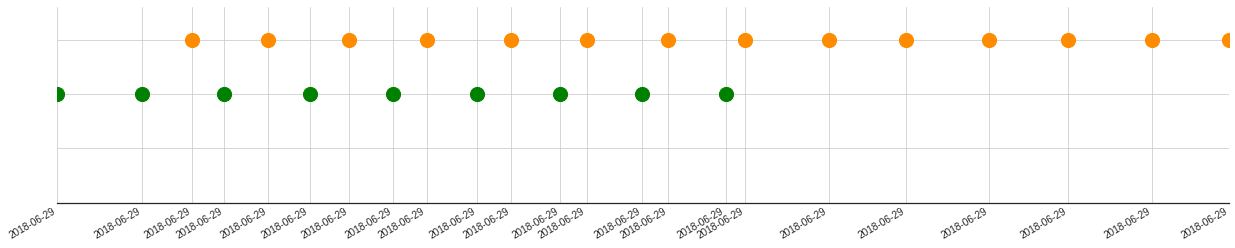

In [341]:
x1 = pd.to_datetime(df1.index)
y1 = df1.workers_count.values
x2 = pd.to_datetime(df2.index)
y2 = df2.workers_count.values

fig, ax = plt.subplots(figsize=(21,4))
ax.scatter(x1, [1]*len(x1), marker='o', s=200, color='green')
ax.scatter(x2, [1.5]*len(x2), marker='o', s=200, color='darkorange')

fig.autofmt_xdate()
plt.grid(True)
plt.ylim(0, 1.8)

#ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.get_yaxis().set_ticklabels([])
space = pd.to_timedelta(2, unit='s') # 1 second interval to prepend
plt.xlim(x1[0] - space, x2[-1] + space)
ax.set_xticks(x1.append(x2), minor=False)
ax.set_yticks([0.5,1,1.5], minor=False)

plt.show()